In [1]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt

from scipy import special
from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-26 14:24:41.133050: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 14:24:41.160193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 14:24:41.160215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 14:24:41.160903: E external/local

## Two element interferometry
It turn out that a simple two antenna radio interferometer can be mathematically represented by a correlation operation, as the signal detectect by two separated radio anteannas

Let assume that we have two antennas located at $\vec{r}_1$ and $\vec{r}_2$, at a given distance $ |\vec{b}| = | \vec{r}_1 - \vec{r}_2 |$ to each other.

<img src="images/intro.png" alt="Drawing" style="width: 250px;"/>


The physical distance between the two dishes result in a time delay between when a signal reaches antenna 1 and 2, corresponding to the amount of time it takes for light to cross the separation vector, $\vec{b}$. Typically this delay is refereed as the __geoterical delay__ and noted $\tau$:

$$ \tau = \frac{\vec{b} \cdot \hat{\vec{s}}}{c} = \frac{| \vec{b} | \cdot cos(\theta)}{c} $$

Where:
- $ \tau $ is the geometrical delay,
- $ \vec{b} $ is the baseline vector representing the separation between two antennas,
- $ \hat{\vec{s}} $ is the direction vector from the source to the phase center, with $ | \hat{\vec{s}}| = 1$. Therefore, $ \theta $ is the angle between the phase center and the source.
- $ c $ is the speed of light.

This delay is a critical consideration in interferometric observations because it affects the coherence of the signals received by the antennas, which in turn impacts the quality of the interferometric data. By precisely measuring and accounting for these geometrical delays, interferometric data can be properly calibrated to accurately reconstruct images of astronomical objects with high spatial resolution.

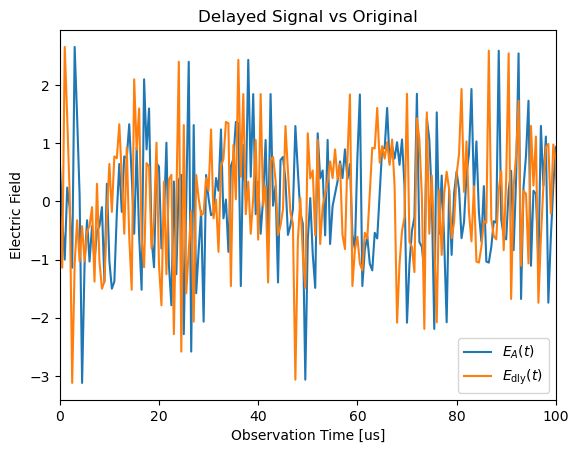

In [2]:
np.random.seed(2023)

SIZE = 1000
freq_obs = 2. * u.MHz

t = np.arange(SIZE) / freq_obs

fqs = np.fft.fftfreq(t.size, np.diff(t.value)[0]) *u.MHz # in MHz (same unit as t)
tau = 2 * u.us

el = np.random.normal(size=SIZE)
el_dly = np.fft.ifft(np.fft.fft(el) * np.exp(2j*np.pi*tau*fqs))

plt.plot(t, el, label=r"$E_A(t)$")
plt.plot(t , el_dly, label=r"$E_{\rm dly}(t)$")
plt.title("Delayed Signal vs Original")
plt.xlabel('Observation Time [%s]' %t.to('us').unit), plt.ylabel('Electric Field')
plt.xlim(0, 100)
plt.legend()

## Correlation bewteen two antennas

The _electric field_ $ E_\nu(t)$ from a source in the sky is detected from atenna 1 and 2 as as a _voltage_:

$$ v_1(t) = A_1( \hat{\vec{s}} ) \cdot E_1(t)$$
$$ v_2(t) = A_2( \hat{\vec{s}} ) \cdot E_2(t-\tau)$$

Here, $ A_n $ is the beam pattern, and it refers to the directional sensitivity pattern of a radio telescope. It describes how the telescope responds to incoming radio waves from different directions in the sky. Generally, we assume ther are the same across multiple antennas, but that is not alwasy true!

In the previous tutorial, we demonstrated with the _convolutional theorem_ that the time-difference (shift) can be regarded as a convolution. We can now write downt the response of baseline (response between two antennas), referred as __visibility__, $ V $, as a correlated signal:

$$ V_{1,\,2} (\nu, t) = \left<E_1(t)\cdot E^*_2(t-\tau) \right> = \mathcal{F}[v_1(t)]\cdot \mathcal{F}[v^*_2(t-\tau)]$$

Let's simualte this and ignore the beam patter (see later tutorial)

(Text(0.5, 0, 'frequency [MHz]'), Text(0, 0.5, 'Visibility $V$ [Jy]'))

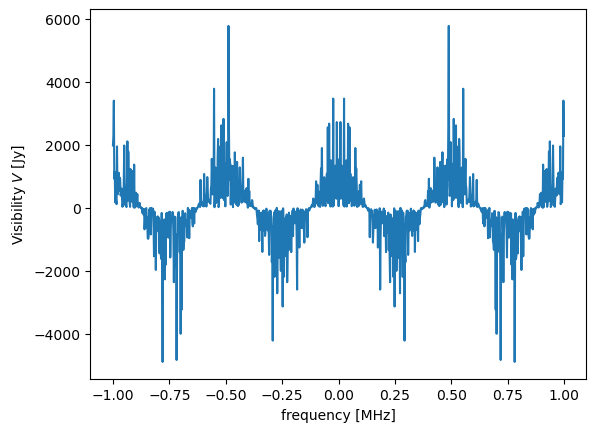

In [3]:
# here we define the voltage and we ignore the beam pattern
v_1 = el
v_2 = el_dly

# calculate the visibility (FFT and multiply)
V_12 = np.fft.fft(v_1) * np.conj(np.fft.fft(v_2))

# plot correlation
plt.plot(np.fft.fftshift(fqs), np.fft.fftshift(V_12))
plt.xlabel('frequency [%s]' %fqs.unit), plt.ylabel(r'Visibility $V$ [Jy]')

As we learn from the previous notebook, we know need to inverse Fourier the visibility to retrive back the time signal, Therefore:

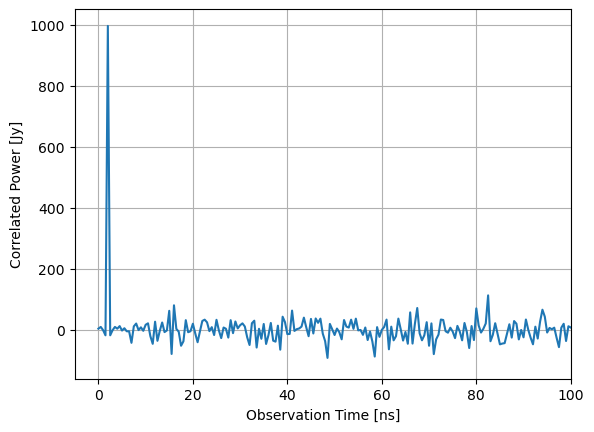

In [4]:
plt.plot(t, np.fft.ifft(V_12))
plt.ylabel('Correlated Power [Jy]')
plt.xlabel('Observation Time [ns]')
plt.xlim(-5, 100)
plt.grid()

<u>Question</u>:
- At which time does the signal peak?
- Why it peak at that specific time?
- What happend if we select $ \tau = 10\,\mu s$